In [18]:
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone
from scipy.stats import iqr
from sklearn.preprocessing import PowerTransformer

In [2]:
user_df = pd.read_csv('../data/users.csv')
user_df.head()

,user_id,birth_year,record_date,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
0,user_0,1989,2019-01-13 05:15:15.599466,STANDARD,1.0,1.0,3,0,0
1,user_1,1975,2019-01-29 03:38:46.676876,STANDARD,NaN,NaN,21,0,0
2,user_2,1987,2019-01-18 19:17:31.229096,STANDARD,0.0,0.0,21,0,0
3,user_3,1994,2019-01-15 18:47:56.723104,STANDARD,1.0,0.0,0,0,0
4,user_4,1985,2019-01-11 00:36:46.673673,STANDARD,NaN,NaN,2,0,0


In [3]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19430 entries, 0 to 19429
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   user_id                                   19430 non-null  object 
 1   birth_year                                19430 non-null  int64  
 2   record_date                               19430 non-null  object 
 3   plan                                      19430 non-null  object 
 4   attributes_notifications_marketing_push   12820 non-null  float64
 5   attributes_notifications_marketing_email  12820 non-null  float64
 6   num_contacts                              19430 non-null  int64  
 7   num_referrals                             19430 non-null  int64  
 8   num_successful_referrals                  19430 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 1.3+ MB


In [4]:
trans_df = pd.read_csv('../data/trans.csv')
trans_df.head()

,record_date,user_id,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id
0,2019-04-03T03:34:21.784Z,user_898,NaN,4.55,transaction_0,COMPLETED,type_0
1,2020-03-19T06:15:59.537Z,user_1652,FALSE,15.50,transaction_1,COMPLETED,type_1
2,2020-03-18T18:53:41.323Z,user_1652,FALSE,43.40,transaction_2,COMPLETED,type_1
3,2020-03-22T14:20:01.513Z,user_1652,NaN,10043.01,transaction_3,COMPLETED,type_0
4,2020-03-22T05:42:50.316Z,user_5509,FALSE,43.81,transaction_4,COMPLETED,type_1


In [5]:
trans_df

,record_date,user_id,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id
0,2019-04-03T03:34:21.784Z,user_898,NaN,4.55,transaction_0,COMPLETED,type_0
1,2020-03-19T06:15:59.537Z,user_1652,FALSE,15.50,transaction_1,COMPLETED,type_1
2,2020-03-18T18:53:41.323Z,user_1652,FALSE,43.40,transaction_2,COMPLETED,type_1
3,2020-03-22T14:20:01.513Z,user_1652,NaN,10043.01,transaction_3,COMPLETED,type_0
4,2020-03-22T05:42:50.316Z,user_5509,FALSE,43.81,transaction_4,COMPLETED,type_1
...,...,...,...,...,...,...,...
1048571,2020-05-06T09:13:31.681Z,user_1189,NaN,4.26,transaction_1048572,COMPLETED,type_0
1048572,2020-05-04T13:49:32.291Z,user_631,NaN,21.28,transaction_1048573,COMPLETED,type_0
1048573,2020-05-05T09:21:37.971Z,user_1585,NaN,21.28,transaction_1048574,COMPLETED,type_0
1048574,2020-05-03T11:29:16.573Z,user_3296,FALSE,4.17,transaction_1048575,COMPLETED,type_1


In [6]:
trans_df['record_date'] = pd.to_datetime(trans_df['record_date'], utc=True)
user_df['record_date'] = pd.to_datetime(user_df['record_date'], utc=True)

In [8]:
last_day = trans_df['record_date'].max()
last_day

Timestamp('2020-05-14 21:38:40.194000+0000', tz='UTC')

In [9]:
user_df['user_days'] = (last_day-user_df['record_date']).dt.days
user_df

,user_id,birth_year,record_date,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,user_days
0,user_0,1989,2019-01-13 05:15:15.599466+00:00,STANDARD,1.0,1.0,3,0,0,487
1,user_1,1975,2019-01-29 03:38:46.676876+00:00,STANDARD,NaN,NaN,21,0,0,471
2,user_2,1987,2019-01-18 19:17:31.229096+00:00,STANDARD,0.0,0.0,21,0,0,482
3,user_3,1994,2019-01-15 18:47:56.723104+00:00,STANDARD,1.0,0.0,0,0,0,485
4,user_4,1985,2019-01-11 00:36:46.673673+00:00,STANDARD,NaN,NaN,2,0,0,489
...,...,...,...,...,...,...,...,...,...,...
19425,user_19425,1994,2019-12-14 08:20:14.700048+00:00,STANDARD,1.0,1.0,17,0,0,152
19426,user_19426,1977,2019-12-28 05:37:36.863792+00:00,STANDARD,1.0,1.0,0,0,0,138
19427,user_19427,1991,2019-12-23 11:07:11.611503+00:00,STANDARD,1.0,1.0,13,0,0,143
19428,user_19428,1984,2019-12-03 14:09:34.164270+00:00,STANDARD,NaN,NaN,0,0,0,163


In [10]:
trans_df = trans_df.loc[trans_df.trans_state=='COMPLETED']

In [11]:
len(trans_df.user_id.unique())

9415

In [12]:
len(user_df.user_id.unique())

19428

In [13]:
types = trans_df.trans_type_id.unique()
n_types = len(types)
eps = 0.000001

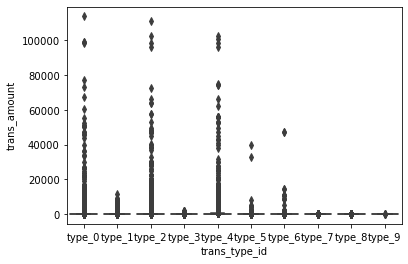

In [15]:
sns.boxplot(y='trans_amount', data=trans_df,x='trans_type_id');

/Users/binxuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/binxuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


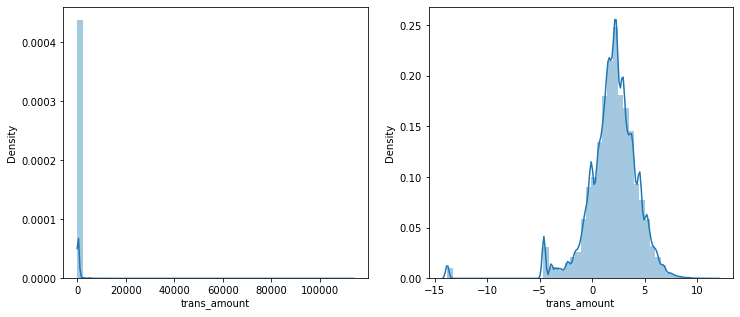

In [16]:
fig, ax=plt.subplots(ncols=2, figsize=(12,5))
sns.distplot(trans_df.trans_amount, ax=ax[0])
sns.distplot(np.log(trans_df.trans_amount+eps), ax=ax[1]);

/Users/binxuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/binxuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/binxuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

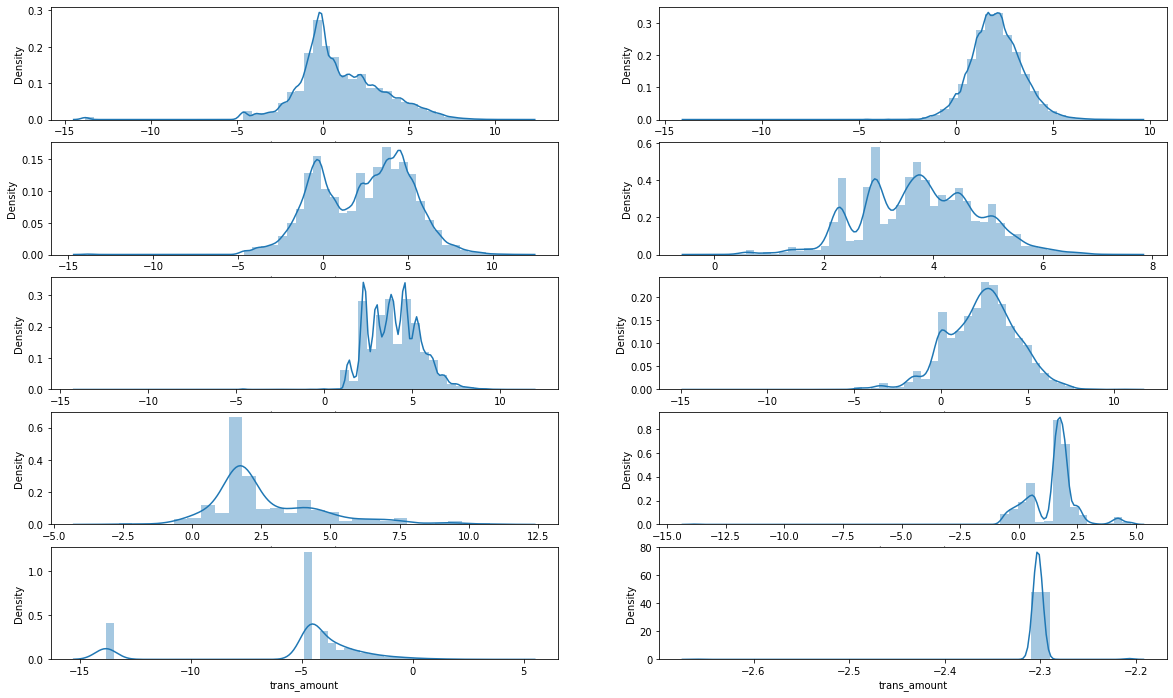

In [17]:
fig, ax = plt.subplots(ncols=np.int(n_types/5), nrows=5, figsize=(20,12))
for e in enumerate(types):
    sns.distplot(np.log(trans_df.loc[trans_df.trans_type_id==e[1], 'trans_amount']+eps), ax=ax[np.int(e[0]/2), np.int(e[0]%2)])

In [19]:
trans_df[['trans_type_id','trans_amount']].groupby('trans_type_id').describe()

trans_amount                                               \
                     count        mean          std   min    25%    50%   
trans_type_id                                                             
type_0            169715.0   70.666766   862.577957  0.00   0.60   1.70   
type_1            491184.0   20.513523    79.276388  0.00   3.40   7.56   
type_2             73267.0  192.517717  1460.246400  0.00   0.98  15.64   
type_3             29445.0   72.911605    95.029790  0.83  20.00  42.55   
type_4            118126.0  188.179155  1137.399929  0.00  17.90  50.00   
type_5              5353.0   76.457056   741.979953  0.00   2.94  12.20   
type_6               622.0  407.444196  2978.788439  0.07   4.99   6.80   
type_7              9254.0    7.721020    14.259221  0.00   1.99   5.10   
type_8             28578.0    0.101275     0.791175  0.00   0.01   0.01   
type_9               521.0    0.100019     0.001581  0.07   0.10   0.10   

                                   
                   75%        max  
trans_type_id                      
type_0          11.930  113857.61  
type_1          17.700   11618.57  
type_2          92.260  111091.19  
type_3          87.480    1703.83  
type_4         150.000  102471.85  
type_5          40.300   40000.00  
type_6          44.775   47024.18  
type_7           6.990     120.00  
type_8           0.030      57.47  
type_9           0.100       0.11

In [20]:
trans_df.groupby('trans_type_id').trans_amount.quantile(.75) + \
    1.5*(trans_df.groupby('trans_type_id').trans_amount.quantile(.75) - \
    trans_df.groupby('trans_type_id').trans_amount.quantile(.25))

trans_type_id
type_0     28.9250
type_1     39.1500
type_2    229.1800
type_3    188.7000
type_4    348.1500
type_5     96.3400
type_6    104.4525
type_7     14.4900
type_8      0.0600
type_9      0.1000
Name: trans_amount, dtype: float64

In [21]:
am_uf=trans_df.trans_amount.quantile(.75)+1.5*iqr(trans_df.trans_amount)
am_uf

68.78

In [22]:
trans_df.groupby('trans_type_id').describe()

trans_amount                                               \
                     count        mean          std   min    25%    50%   
trans_type_id                                                             
type_0            169715.0   70.666766   862.577957  0.00   0.60   1.70   
type_1            491184.0   20.513523    79.276388  0.00   3.40   7.56   
type_2             73267.0  192.517717  1460.246400  0.00   0.98  15.64   
type_3             29445.0   72.911605    95.029790  0.83  20.00  42.55   
type_4            118126.0  188.179155  1137.399929  0.00  17.90  50.00   
type_5              5353.0   76.457056   741.979953  0.00   2.94  12.20   
type_6               622.0  407.444196  2978.788439  0.07   4.99   6.80   
type_7              9254.0    7.721020    14.259221  0.00   1.99   5.10   
type_8             28578.0    0.101275     0.791175  0.00   0.01   0.01   
type_9               521.0    0.100019     0.001581  0.07   0.10   0.10   

                                   
                   75%        max  
trans_type_id                      
type_0          11.930  113857.61  
type_1          17.700   11618.57  
type_2          92.260  111091.19  
type_3          87.480    1703.83  
type_4         150.000  102471.85  
type_5          40.300   40000.00  
type_6          44.775   47024.18  
type_7           6.990     120.00  
type_8           0.030      57.47  
type_9           0.100       0.11

In [23]:
am_outliers = trans_df.loc[trans_df.trans_amount>am_uf,:]

In [24]:
am_outliers.describe()

,trans_amount
count,127600.000000
mean,405.751377
std,1844.432460
min,68.790000
25%,99.420000
50%,156.360000
75%,300.000000
max,113857.610000


In [25]:
def scale_by_type (df, col_num, col_cat):
    col_scaled = df[[col_num, col_cat]].groupby(col_cat)[col_num].\
              transform(lambda x: (np.log(x+eps) - np.log(x+eps).min()) / (np.log(x+eps).max()-np.log(x+eps).min()))
    return col_scaled

trans_df['trans_amount_sc'] = scale_by_type(trans_df,'trans_amount', 'trans_type_id')
trans_df

<ipython-input-25-d94717b06e66>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_df['trans_amount_sc']=scale_by_type(trans_df,'trans_amount', 'trans_type_id')


,record_date,user_id,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,trans_amount_sc
0,2019-04-03 03:34:21.784000+00:00,user_898,NaN,4.55,transaction_0,COMPLETED,type_0,0.602188
1,2020-03-19 06:15:59.537000+00:00,user_1652,FALSE,15.50,transaction_1,COMPLETED,type_1,0.714379
2,2020-03-18 18:53:41.323000+00:00,user_1652,FALSE,43.40,transaction_2,COMPLETED,type_1,0.758805
3,2020-03-22 14:20:01.513000+00:00,user_1652,NaN,10043.01,transaction_3,COMPLETED,type_0,0.904625
4,2020-03-22 05:42:50.316000+00:00,user_5509,FALSE,43.81,transaction_4,COMPLETED,type_1,0.759211
...,...,...,...,...,...,...,...,...
1048571,2020-05-06 09:13:31.681000+00:00,user_1189,NaN,4.26,transaction_1048572,COMPLETED,type_0,0.599601
1048572,2020-05-04 13:49:32.291000+00:00,user_631,NaN,21.28,transaction_1048573,COMPLETED,type_0,0.662783
1048573,2020-05-05 09:21:37.971000+00:00,user_1585,NaN,21.28,transaction_1048574,COMPLETED,type_0,0.662783
1048574,2020-05-03 11:29:16.573000+00:00,user_3296,FALSE,4.17,transaction_1048575,COMPLETED,type_1,0.657728


In [26]:
trans_df[['trans_amount_sc','trans_type_id']].groupby('trans_type_id').describe()

trans_amount_sc                                               \
                        count      mean       std  min       25%       50%   
trans_type_id                                                                
type_0               169715.0  0.581062  0.098059  0.0  0.522609  0.563517   
type_1               491184.0  0.685024  0.055613  0.0  0.648920  0.683400   
type_2                73267.0  0.636559  0.106933  0.0  0.542405  0.651317   
type_3                29445.0  0.516480  0.136522  0.0  0.417212  0.516196   
type_4               118126.0  0.701803  0.057737  0.0  0.658715  0.699232   
type_5                 5353.0  0.664053  0.081980  0.0  0.610103  0.668395   
type_6                  622.0  0.396764  0.146826  0.0  0.317990  0.341056   
type_7                 9254.0  0.821008  0.059203  0.0  0.779640  0.830229   
type_8                28578.0  0.481513  0.210995  0.0  0.515507  0.515507   
type_9                  521.0  0.789234  0.039238  0.0  0.789129  0.789129   

                              
                    75%  max  
trans_type_id                 
type_0         0.640051  1.0  
type_1         0.720106  1.0  
type_2         0.721098  1.0  
type_3         0.610694  1.0  
type_4         0.742565  1.0  
type_5         0.717342  1.0  
type_6         0.481522  1.0  
type_7         0.847175  1.0  
type_8         0.576992  1.0  
type_9         0.789129  1.0

/Users/binxuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/binxuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


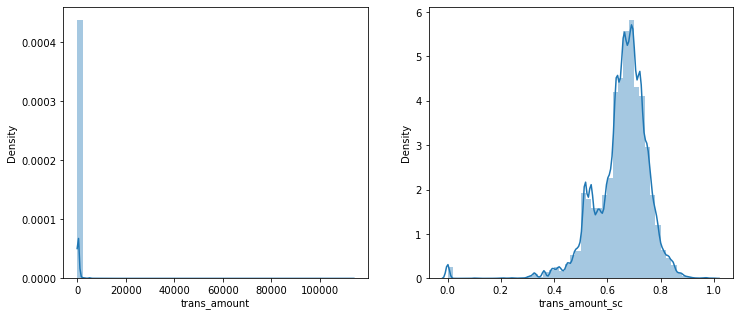

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
sns.distplot(trans_df.trans_amount, ax=ax[0])
sns.distplot(trans_df.trans_amount_sc, ax=ax[1]);

In [28]:
trans_df = trans_df.set_index(['user_id']).sort_values('record_date', ascending=True)

<AxesSubplot:xlabel='trans_type_id', ylabel='trans_amount_sc'>

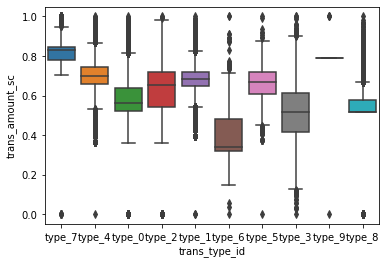

In [29]:
sns.boxplot(y='trans_amount_sc', data=trans_df,x='trans_type_id')

In [30]:
trans_df['next_trans'] = trans_df['record_date'].groupby("user_id").shift(-1)
trans_df

,record_date,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,trans_amount_sc,next_trans
user_id,,,,,,,,
user_375,2019-01-02 07:09:41.673000+00:00,NaN,5.00,transaction_594289,COMPLETED,type_7,0.829164,2019-07-02 04:59:06.620000+00:00
user_657,2019-01-02 16:32:22.172000+00:00,NaN,5.00,transaction_9393,COMPLETED,type_7,0.829164,2020-01-15 11:26:30.226000+00:00
user_46,2019-01-02 20:36:25.868000+00:00,NaN,42.55,transaction_545571,COMPLETED,type_4,0.692868,2019-01-27 18:36:59.351000+00:00
user_472,2019-01-02 21:38:32.797000+00:00,NaN,8.51,transaction_545576,COMPLETED,type_4,0.629387,2019-01-02 21:40:02.619000+00:00
user_472,2019-01-02 21:40:02.619000+00:00,NaN,5.11,transaction_545575,COMPLETED,type_7,0.830334,2019-01-10 19:29:43.251000+00:00
...,...,...,...,...,...,...,...,...
user_6877,2020-05-14 04:12:18.738000+00:00,NaN,33.07,transaction_755964,COMPLETED,type_4,0.682927,2020-05-14 07:04:08.838000+00:00
user_1102,2020-05-14 06:51:17.491000+00:00,NaN,100.00,transaction_181734,COMPLETED,type_2,0.724265,2020-05-14 17:36:51.926000+00:00
user_6877,2020-05-14 07:04:08.838000+00:00,NaN,33.07,transaction_767914,COMPLETED,type_4,0.682927,NaT


In [31]:
trans_df['time_diff'] = (trans_df['next_trans'] - trans_df['record_date']).dt.days

In [32]:
trans_df.sort_values(['user_id','record_date'] )

,record_date,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,trans_amount_sc,next_trans,time_diff
user_id,,,,,,,,,
user_0,2019-01-16 23:24:18.666000+00:00,NaN,39.77,transaction_237281,COMPLETED,type_4,0.690203,2019-01-16 23:30:38.475000+00:00,0.0
user_0,2019-01-16 23:30:38.475000+00:00,NaN,1.99,transaction_233630,COMPLETED,type_7,0.779640,2019-01-17 01:39:17.613000+00:00,0.0
user_0,2019-01-17 01:39:17.613000+00:00,NaN,37.78,transaction_233675,COMPLETED,type_2,0.685993,2019-01-17 01:52:38.943000+00:00,0.0
user_0,2019-01-17 01:52:38.943000+00:00,NaN,5.66,transaction_546121,COMPLETED,type_0,0.610763,2019-01-17 07:49:06.142000+00:00,0.0
user_0,2019-01-17 07:49:06.142000+00:00,NaN,4.26,transaction_545586,COMPLETED,type_0,0.599601,2019-01-18 11:02:38.350000+00:00,1.0
...,...,...,...,...,...,...,...,...,...
user_9999,2020-03-25 17:33:46.384000+00:00,NaN,0.49,transaction_950841,COMPLETED,type_0,0.514654,2020-04-20 01:29:10.364000+00:00,25.0
user_9999,2020-04-20 01:29:10.364000+00:00,NaN,34.04,transaction_1011789,COMPLETED,type_4,0.684067,2020-04-20 01:36:37.861000+00:00,0.0
user_9999,2020-04-20 01:36:37.861000+00:00,TRUE,16.54,transaction_1011546,COMPLETED,type_1,0.717181,2020-04-20 01:36:37.989000+00:00,0.0


In [33]:
trans_df['last_date'] = trans_df.groupby('user_id')['record_date'].transform('max')

In [34]:
trans_df['record_date'].max()

Timestamp('2020-05-14 21:38:40.194000+0000', tz='UTC')

In [35]:
trans_df['last_trans'] = (trans_df['record_date'].max() - trans_df['last_date']).dt.days

In [36]:
trans_df

,record_date,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,trans_amount_sc,next_trans,time_diff,last_date,last_trans
user_id,,,,,,,,,,,
user_375,2019-01-02 07:09:41.673000+00:00,NaN,5.00,transaction_594289,COMPLETED,type_7,0.829164,2019-07-02 04:59:06.620000+00:00,180.0,2019-08-23 08:57:13.994000+00:00,265
user_657,2019-01-02 16:32:22.172000+00:00,NaN,5.00,transaction_9393,COMPLETED,type_7,0.829164,2020-01-15 11:26:30.226000+00:00,377.0,2020-05-07 17:26:06.194000+00:00,7
user_46,2019-01-02 20:36:25.868000+00:00,NaN,42.55,transaction_545571,COMPLETED,type_4,0.692868,2019-01-27 18:36:59.351000+00:00,24.0,2019-02-09 17:22:23.152000+00:00,460
user_472,2019-01-02 21:38:32.797000+00:00,NaN,8.51,transaction_545576,COMPLETED,type_4,0.629387,2019-01-02 21:40:02.619000+00:00,0.0,2020-05-06 11:34:37.631000+00:00,8
user_472,2019-01-02 21:40:02.619000+00:00,NaN,5.11,transaction_545575,COMPLETED,type_7,0.830334,2019-01-10 19:29:43.251000+00:00,7.0,2020-05-06 11:34:37.631000+00:00,8
...,...,...,...,...,...,...,...,...,...,...,...
user_6877,2020-05-14 04:12:18.738000+00:00,NaN,33.07,transaction_755964,COMPLETED,type_4,0.682927,2020-05-14 07:04:08.838000+00:00,0.0,2020-05-14 07:04:08.838000+00:00,0
user_1102,2020-05-14 06:51:17.491000+00:00,NaN,100.00,transaction_181734,COMPLETED,type_2,0.724265,2020-05-14 17:36:51.926000+00:00,0.0,2020-05-14 21:38:40.194000+00:00,0
user_6877,2020-05-14 07:04:08.838000+00:00,NaN,33.07,transaction_767914,COMPLETED,type_4,0.682927,NaT,NaN,2020-05-14 07:04:08.838000+00:00,0


In [37]:
trans_month = trans_df.groupby(['user_id', trans_df['record_date'].dt.year,trans_df['record_date'].dt.month]).\
       agg({'trans_id':'count', 'trans_amount_sc':['mean','median','std'], 
            'time_diff':['mean','median','std'],
            'last_trans':['max'] })

In [38]:
trans_month.columns = ['count','mean_amount', 'median_amount', 'std_amount', 'mean_days','median_days','std_days', \
                       'last_trans_days']

In [39]:
trans_month.index.names = ['user_id', 'trans_yr', 'trans_mo']

In [40]:
trans_month.head(30)

count  mean_amount  median_amount  std_amount  \
user_id trans_yr trans_mo                                                  
user_0  2019     1            10     0.651143       0.645195    0.059471   
                 2            10     0.634493       0.705072    0.155264   
                 3            24     0.664821       0.677453    0.073461   
                 4             6     0.709085       0.705072    0.064400   
                 5            16     0.631191       0.630519    0.039976   
                 6            24     0.657154       0.667275    0.055954   
                 7            28     0.685061       0.694603    0.049853   
                 8            17     0.647944       0.632883    0.075342   
                 9             2     0.661801       0.661801    0.001488   
                 10           21     0.655638       0.662853    0.076357   
                 11           10     0.634961       0.626037    0.064005   
                 12            9     0.634800       0.623124    0.058378   
        2020     1             2     0.586663       0.586663    0.023984   
                 2             9     0.663257       0.685993    0.064437   
                 3            14     0.609690       0.593764    0.069868   
                 4            43     0.692738       0.688012    0.054844   
                 5             1     0.683285       0.683285         NaN   
user_1  2019     3             7     0.720843       0.722222    0.069015   
                 4            18     0.732863       0.742565    0.043295   
                 5             5     0.713199       0.726572    0.055715   
                 6            11     0.672361       0.676273    0.035107   
                 7             4     0.704706       0.713181    0.042222   
                 8             3     0.708333       0.733764    0.049092   
                 9             7     0.697501       0.699187    0.050873   
                 11            5     0.683652       0.679084    0.017510   
                 12            6     0.700117       0.713186    0.041933   
        2020     1             1     0.759557       0.759557         NaN   
                 2             6     0.744793       0.749928    0.034925   
user_10 2019     1             7     0.657523       0.642501    0.056509   
                 2            14     0.678868       0.685009    0.043886   

                           mean_days  median_days   std_days  last_trans_days  
user_id trans_yr trans_mo                                                      
user_0  2019     1          1.400000          0.0   4.087923               12  
                 2          2.500000          0.0   5.892557               12  
                 3          1.291667          0.0   4.666990               12  
                 4          3.833333          0.5   6.400521               12  
                 5          1.687500          0.0   5.300550               12  
                 6          1.125000          0.0   2.251811               12  
                 7          0.928571          0.0   1.942289               12  
                 8          1.823529          0.0   7.011021               12  
                 9         15.000000         15.0  21.213203               12  
                 10         0.857143          0.0   2.007130               12  
                 11         4.000000          1.0   6.863753               12  
                 12         4.555556          1.0  12.176936               12  
        2020     1          2.500000          2.5   3.535534               12  
                 2          4.111111          0.0   7.817360               12  
                 3          1.285714          0.0   1.898525               12  
                 4          0.418605          0.0   1.561936               12  
                 5               NaN          NaN        NaN               12  
user_1  2019     3          3.857143          0.0  10.205041              

In [41]:
idx = pd.IndexSlice
trans_3_month = trans_month.loc[idx[:, 2020,3:5], ['count', 'mean_amount', 'mean_days']].groupby('user_id').\
                agg({'count':['mean'], 'mean_amount':['mean'],'mean_days':['mean']})
trans_3_month

,count,mean_amount,mean_days
,mean,mean,mean
user_id,,,
user_0,19.333333,0.661904,0.852159
user_10,14.666667,0.613393,1.297619
user_100,2.666667,0.738866,10.666667
user_1002,9.000000,0.720195,1.000000
user_1003,2.500000,0.772758,14.000000
...,...,...,...
user_9994,9.666667,0.662506,1.683473
user_9995,12.333333,0.572313,4.301075


In [42]:
trans_3_month.columns=['count', 'amount', 'days']

In [43]:
trans_3_month

,count,amount,days
user_id,,,
user_0,19.333333,0.661904,0.852159
user_10,14.666667,0.613393,1.297619
user_100,2.666667,0.738866,10.666667
user_1002,9.000000,0.720195,1.000000
user_1003,2.500000,0.772758,14.000000
...,...,...,...
user_9994,9.666667,0.662506,1.683473
user_9995,12.333333,0.572313,4.301075
user_9996,25.000000,0.691703,0.840090


In [44]:
trans_month_past = trans_month.drop(trans_month.loc[idx[:, 2020,3:5], :].index)
trans_month_past

count  mean_amount  median_amount  std_amount  \
user_id   trans_yr trans_mo                                                  
user_0    2019     1            10     0.651143       0.645195    0.059471   
                   2            10     0.634493       0.705072    0.155264   
                   3            24     0.664821       0.677453    0.073461   
                   4             6     0.709085       0.705072    0.064400   
                   5            16     0.631191       0.630519    0.039976   
...                            ...          ...            ...         ...   
user_9999 2019     8             1     0.830229       0.830229         NaN   
                   10           11     0.591707       0.629387    0.111849   
                   11            2     0.596063       0.596063    0.130735   
                   12            1     0.448090       0.448090         NaN   
          2020     2             2     0.529884       0.529884    0.004994   

                             mean_days  median_days   std_days  \
user_id   trans_yr trans_mo                                      
user_0    2019     1          1.400000          0.0   4.087923   
                   2          2.500000          0.0   5.892557   
                   3          1.291667          0.0   4.666990   
                   4          3.833333          0.5   6.400521   
                   5          1.687500          0.0   5.300550   
...                                ...          ...        ...   
user_9999 2019     8         60.000000         60.0        NaN   
                   10         1.818182          0.0   2.857208   
                   11        18.500000         18.5  24.748737   
                   12        71.000000         71.0        NaN   
          2020     2         14.500000         14.5  20.506097   

                             last_trans_days  
user_id   trans_yr trans_mo                   
user_0    2019     1                      12  
                   2                      12  
                   3                      12  
                   4                      12  
                   5                      12  
...                                      ...  
user_9999 2019     8                       9  
                   10                      9  
                   11                      9  
                   12                      9  
          2020     2                       9  

[54872 rows x 8 columns]

In [45]:
trans = trans_month_past[['count', 'mean_amount', 'mean_days', 'last_trans_days']].groupby('user_id').\
        agg({'count':['mean'], 'mean_amount':['mean'],'mean_days':['mean'],'last_trans_days':['max'] })

In [46]:
trans.columns=['count', 'amount', 'days', 'last_trans_days']
trans

,count,amount,days,last_trans_days
user_id,,,,
user_0,13.428571,0.651287,3.258101,12
user_1,6.636364,0.712539,7.097212,80
user_10,17.571429,0.658914,1.615844,8
user_100,5.363636,0.753812,14.946970,7
user_1000,5.750000,0.755613,10.144444,323
...,...,...,...,...
user_9995,43.166667,0.595391,0.369805,12
user_9996,22.142857,0.708998,0.924458,24
user_9997,4.000000,0.609678,13.775000,16


In [47]:
trans_user = pd.merge(trans[['count','amount','days', 'last_trans_days']], trans_3_month, on='user_id', how='outer', \
                      suffixes=('', '_last_3_months')).fillna(0)
trans_user = pd.merge(trans_user, user_df[['user_id','user_days']], on='user_id', how='inner', \
                      suffixes=('', '_user')).fillna(0)

In [48]:
trans_user

,user_id,count,amount,days,last_trans_days,count_last_3_months,amount_last_3_months,days_last_3_months,user_days
0,user_0,13.428571,0.651287,3.258101,12.0,19.333333,0.661904,0.852159,487
1,user_1,6.636364,0.712539,7.097212,80.0,0.000000,0.000000,0.000000,471
2,user_10,17.571429,0.658914,1.615844,8.0,14.666667,0.613393,1.297619,496
3,user_100,5.363636,0.753812,14.946970,7.0,2.666667,0.738866,10.666667,485
4,user_1000,5.750000,0.755613,10.144444,323.0,0.000000,0.000000,0.000000,494
...,...,...,...,...,...,...,...,...,...
9411,user_9692,0.000000,0.000000,0.000000,0.0,7.000000,0.749063,1.500000,309
9412,user_9714,0.000000,0.000000,0.000000,0.0,1.000000,0.629387,0.000000,305
9413,user_9741,0.000000,0.000000,0.000000,0.0,3.000000,0.673510,3.555556,306
9414,user_9893,0.000000,0.000000,0.000000,0.0,1.000000,0.654009,0.000000,256


In [49]:
trans_user.to_csv('../data/trans_user.csv', index=True)